In [1]:
!pip install mysql-connector-python

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
from sqlalchemy import create_engine
import urllib.parse

# --- Database Connection (Corrected for special characters in password) ---
db_user = 'root'
# Use urllib.parse.quote_plus to handle special characters like '@'
db_password = urllib.parse.quote_plus('a@147@258@369@A')
db_host = 'localhost'
db_port = '3306'
db_name = 'mavenfuzzyfactory'

# Create a SQLAlchemy engine for pandas
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

print("Database connection successful!")

# --- Visualization Settings ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

Database connection successful!


## Explanation: 
The Technical Reason: Temporary Tables
Here’s a quick breakdown of the issue:

How Temporary Tables Work: When you run a query like CREATE TEMPORARY TABLE ..., that table only exists for your current, active connection to the database. As soon as you disconnect, it vanishes.

How pandas.read_sql() Works: Each time you call pd.read_sql(), it typically opens a new, fresh connection to the database, runs the query, gets the results, and then closes that connection.

The Conflict: If I were to run your scripts as-is, the first call would create the temporary table and then immediately disconnect, causing the table to be destroyed. The very next line of code to SELECT from that table would fail because the table no longer exists.

To solve this, I rewrite the logic from your multi-step scripts (which use temporary tables) into a single, self-contained query using subqueries. This ensures that all the logic is executed on the database in one go, on a single connection, so pandas can receive the final result.

So, while it looks like I'm rewriting them, I'm actually just refactoring them to be compatible with the Python environment while preserving the original analytical logic.

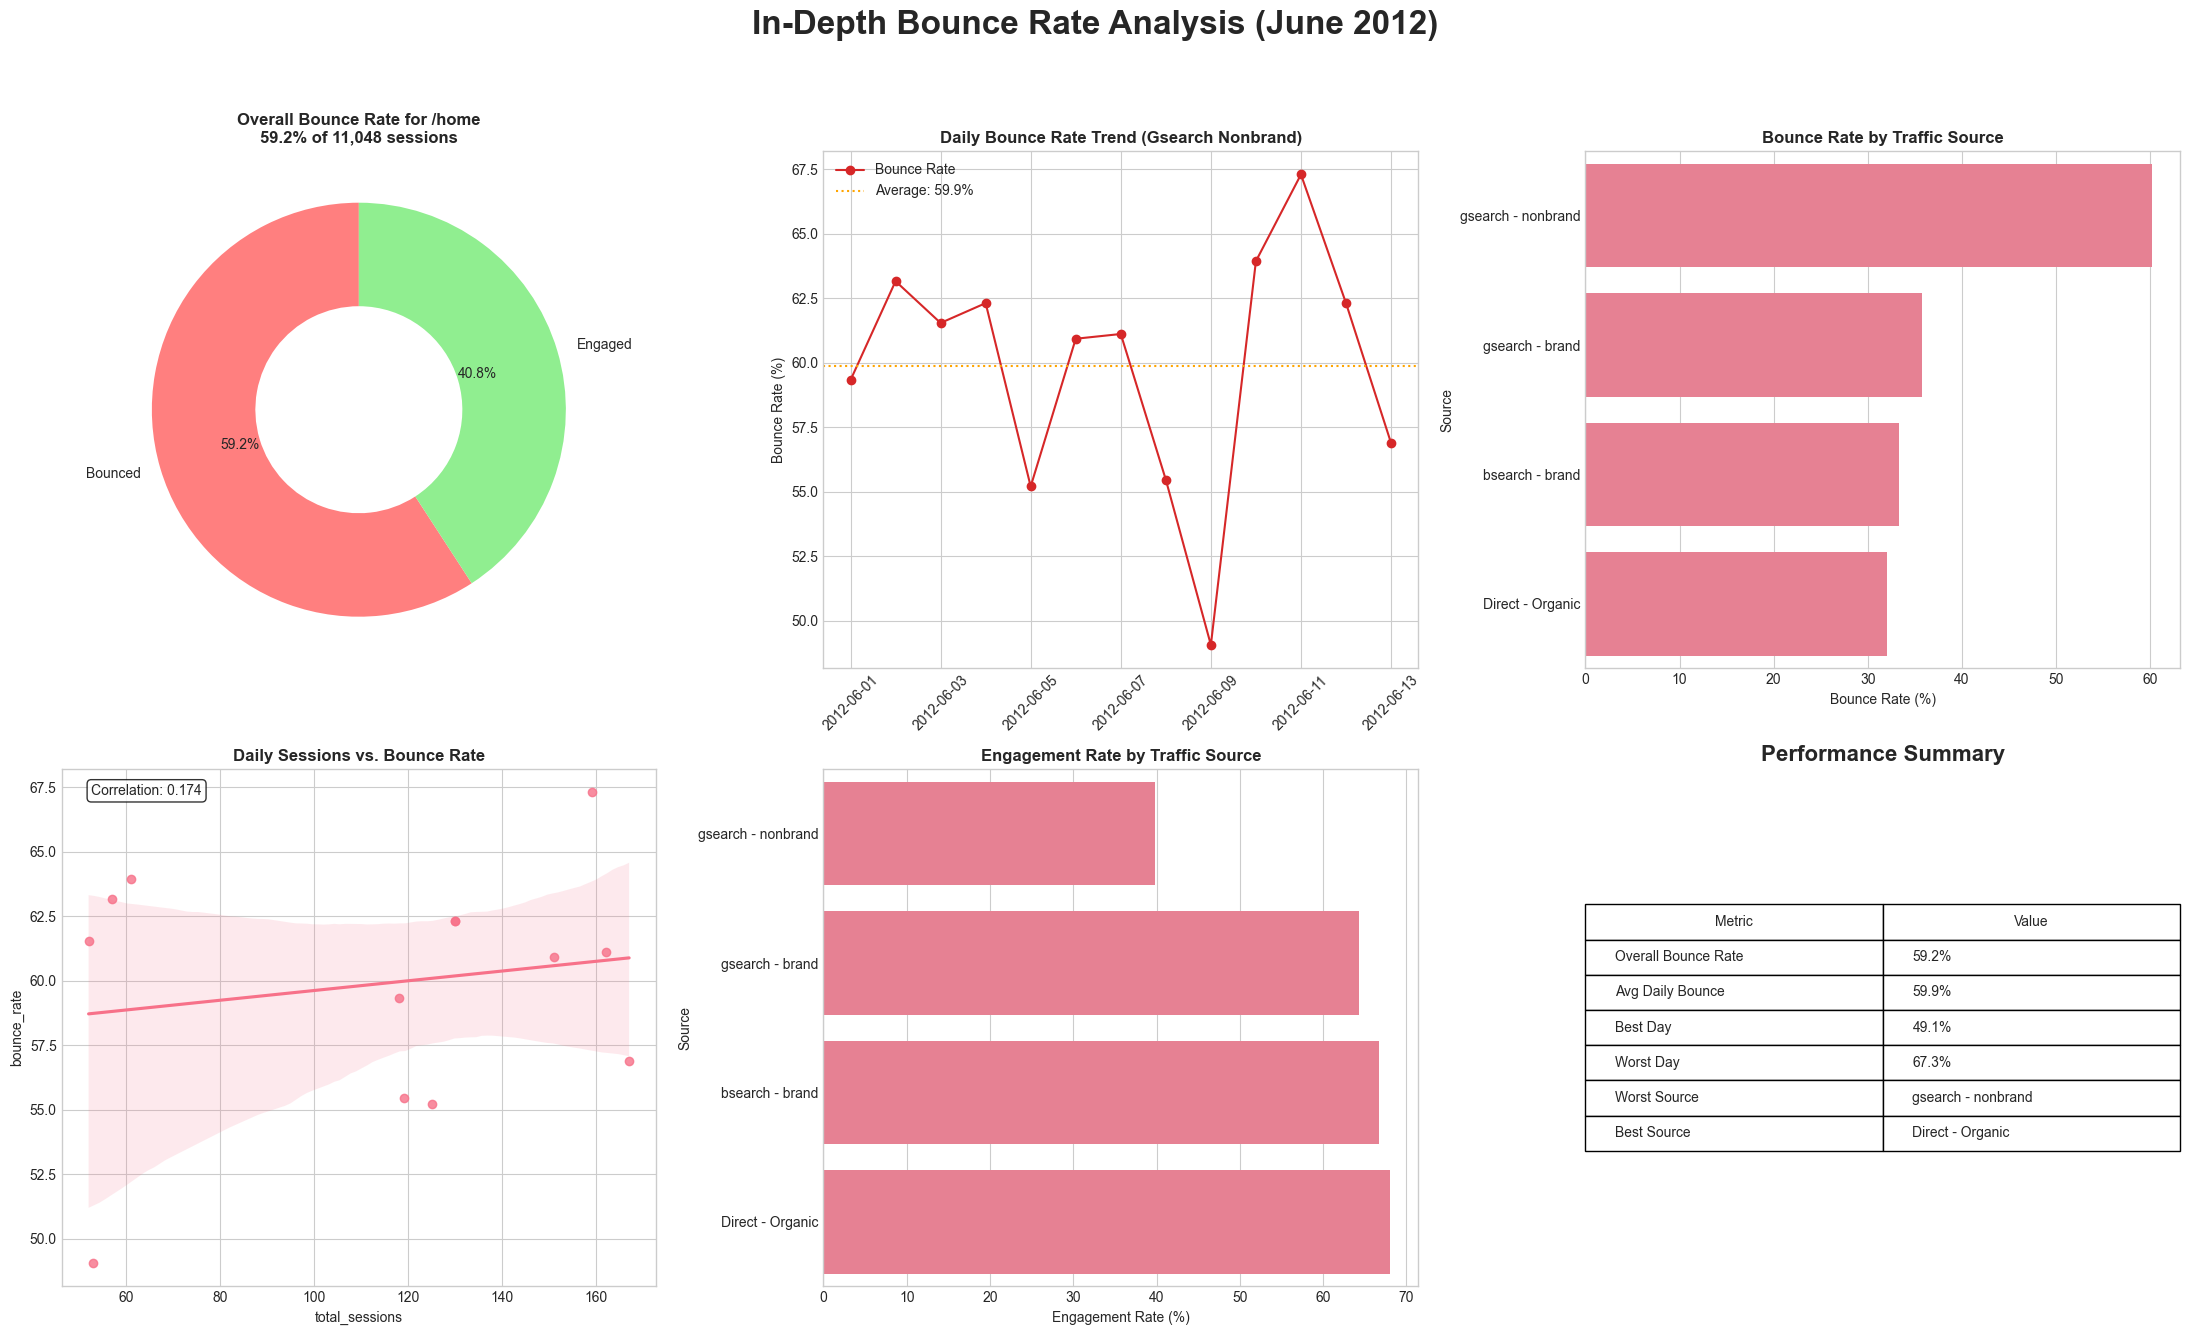

In [4]:
# --- Read Queries for Deeper Bounce Rate Analysis (with corrected GROUP BY clauses) ---

# Query 1: Overall bounce rate for the homepage
q1 = """
SELECT
    sessions_w_lp_url.landing_page,
    COUNT(sessions_w_lp_url.website_session_id) AS sessions_count,
    COUNT(bounced_sessions_only.website_session_id) AS bounced_sessions,
    (COUNT(bounced_sessions_only.website_session_id) / COUNT(sessions_w_lp_url.website_session_id)) * 100 AS bounce_rate
FROM (
    SELECT
        fpd.website_session_id,
        wp.pageview_url AS landing_page
    FROM (
        SELECT
            ws.website_session_id,
            MIN(wp.website_pageview_id) AS min_pv_id
        FROM website_pageviews wp
        LEFT JOIN website_sessions ws ON ws.website_session_id = wp.website_session_id AND ws.created_at < '2012-06-14'
        GROUP BY ws.website_session_id
    ) AS fpd
    LEFT JOIN website_pageviews wp ON wp.website_pageview_id = fpd.min_pv_id
) AS sessions_w_lp_url
LEFT JOIN (
    SELECT
        swlu.website_session_id
    FROM (
        SELECT
            fpd.website_session_id,
            wp.pageview_url AS landing_page
        FROM (
            SELECT
                ws.website_session_id,
                MIN(wp.website_pageview_id) AS min_pv_id
            FROM website_pageviews wp
            LEFT JOIN website_sessions ws ON ws.website_session_id = wp.website_session_id AND ws.created_at < '2012-06-14'
            GROUP BY ws.website_session_id
        ) AS fpd
        LEFT JOIN website_pageviews wp ON wp.website_pageview_id = fpd.min_pv_id
    ) AS swlu
    LEFT JOIN website_pageviews wp ON wp.website_session_id = swlu.website_session_id
    GROUP BY swlu.website_session_id, swlu.landing_page
    HAVING COUNT(wp.website_pageview_id) = 1
) AS bounced_sessions_only ON sessions_w_lp_url.website_session_id = bounced_sessions_only.website_session_id
WHERE sessions_w_lp_url.landing_page = '/home'
GROUP BY sessions_w_lp_url.landing_page;
"""
df_overall_bounce = pd.read_sql(q1, engine)

# Query 2: Daily bounce rates for gsearch nonbrand traffic
q2 = """
SELECT
    DATE(ws.created_at) AS date,
    COUNT(DISTINCT ws.website_session_id) AS total_sessions,
    (COUNT(DISTINCT CASE WHEN pageview_count = 1 THEN ws.website_session_id ELSE NULL END) / COUNT(DISTINCT ws.website_session_id)) * 100 AS bounce_rate
FROM website_sessions ws
LEFT JOIN (
    SELECT website_session_id, COUNT(website_pageview_id) AS pageview_count FROM website_pageviews GROUP BY website_session_id
) AS session_counts ON ws.website_session_id = session_counts.website_session_id
WHERE ws.created_at BETWEEN '2012-06-01' AND '2012-06-14' AND ws.utm_source = 'gsearch' AND ws.utm_campaign = 'nonbrand'
GROUP BY DATE(ws.created_at) ORDER BY date;
"""
df_daily_bounce = pd.read_sql(q2, engine)
df_daily_bounce['date'] = pd.to_datetime(df_daily_bounce['date'])

# Query 3: Bounce rates by traffic source
q3 = """
SELECT
    utm_source, utm_campaign,
    COUNT(DISTINCT ws.website_session_id) AS total_sessions,
    (COUNT(DISTINCT CASE WHEN pageview_count = 1 THEN ws.website_session_id ELSE NULL END) / COUNT(DISTINCT ws.website_session_id)) * 100 AS bounce_rate
FROM website_sessions ws
LEFT JOIN (
    SELECT website_session_id, COUNT(website_pageview_id) AS pageview_count FROM website_pageviews GROUP BY website_session_id
) AS session_counts ON ws.website_session_id = session_counts.website_session_id
WHERE ws.created_at BETWEEN '2012-06-01' AND '2012-06-14'
GROUP BY utm_source, utm_campaign ORDER BY bounce_rate DESC;
"""
df_source_bounce = pd.read_sql(q3, engine)
df_source_bounce['source_label'] = df_source_bounce['utm_source'].fillna('Direct') + ' - ' + df_source_bounce['utm_campaign'].fillna('Organic')

# --- Comprehensive Visualization (recreating your script's dashboard) ---
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('In-Depth Bounce Rate Analysis (June 2012)', fontsize=24, fontweight='bold')

# 1. Overall Bounce Rate Summary
ax1 = axes[0, 0]
sizes = [df_overall_bounce['bounced_sessions'].iloc[0], df_overall_bounce['sessions_count'].iloc[0] - df_overall_bounce['bounced_sessions'].iloc[0]]
ax1.pie(sizes, labels=['Bounced', 'Engaged'], colors=['#ff7f7f', '#90ee90'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))
ax1.set_title(f'Overall Bounce Rate for /home\n{df_overall_bounce["bounce_rate"].iloc[0]:.1f}% of {df_overall_bounce["sessions_count"].iloc[0]:,} sessions', fontweight='bold')

# 2. Daily Bounce Rate Trend
ax2 = axes[0, 1]
ax2.plot(df_daily_bounce['date'], df_daily_bounce['bounce_rate'], marker='o', color='#d62728', label='Bounce Rate')
ax2.set_title('Daily Bounce Rate Trend (Gsearch Nonbrand)', fontweight='bold')
ax2.set_ylabel('Bounce Rate (%)')
ax2.tick_params(axis='x', rotation=45)
avg_bounce = df_daily_bounce['bounce_rate'].mean()
ax2.axhline(y=avg_bounce, color='orange', linestyle=':', label=f'Average: {avg_bounce:.1f}%')
ax2.legend()

# 3. Traffic Source Comparison
ax3 = axes[0, 2]
sns.barplot(x='bounce_rate', y='source_label', data=df_source_bounce, ax=ax3)
ax3.set_title('Bounce Rate by Traffic Source', fontweight='bold')
ax3.set_xlabel('Bounce Rate (%)')
ax3.set_ylabel('Source')

# 4. Daily Sessions vs Bounce Rate Correlation
ax4 = axes[1, 0]
sns.regplot(x='total_sessions', y='bounce_rate', data=df_daily_bounce, ax=ax4)
ax4.set_title('Daily Sessions vs. Bounce Rate', fontweight='bold')
correlation = df_daily_bounce['total_sessions'].corr(df_daily_bounce['bounce_rate'])
ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax4.transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# 5. Engagement Rate Comparison
ax5 = axes[1, 1]
df_source_bounce['engagement_rate'] = 100 - df_source_bounce['bounce_rate']
sns.barplot(x='engagement_rate', y='source_label', data=df_source_bounce.sort_values('engagement_rate'), ax=ax5)
ax5.set_title('Engagement Rate by Traffic Source', fontweight='bold')
ax5.set_xlabel('Engagement Rate (%)')
ax5.set_ylabel('Source')

# 6. Performance Metrics Summary Table
ax6 = axes[1, 2]
ax6.axis('off')
summary_data = [
    ['Overall Bounce Rate', f"{df_overall_bounce['bounce_rate'].iloc[0]:.1f}%"],
    ['Avg Daily Bounce', f"{avg_bounce:.1f}%"],
    ['Best Day', f"{df_daily_bounce['bounce_rate'].min():.1f}%"],
    ['Worst Day', f"{df_daily_bounce['bounce_rate'].max():.1f}%"],
    ['Worst Source', df_source_bounce.loc[df_source_bounce['bounce_rate'].idxmax()]['source_label']],
    ['Best Source', df_source_bounce.loc[df_source_bounce['bounce_rate'].idxmin()]['source_label']]
]
table = ax6.table(cellText=summary_data, colLabels=['Metric', 'Value'], loc='center', cellLoc='left')
table.scale(1, 2)
ax6.set_title('Performance Summary', fontweight='bold', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

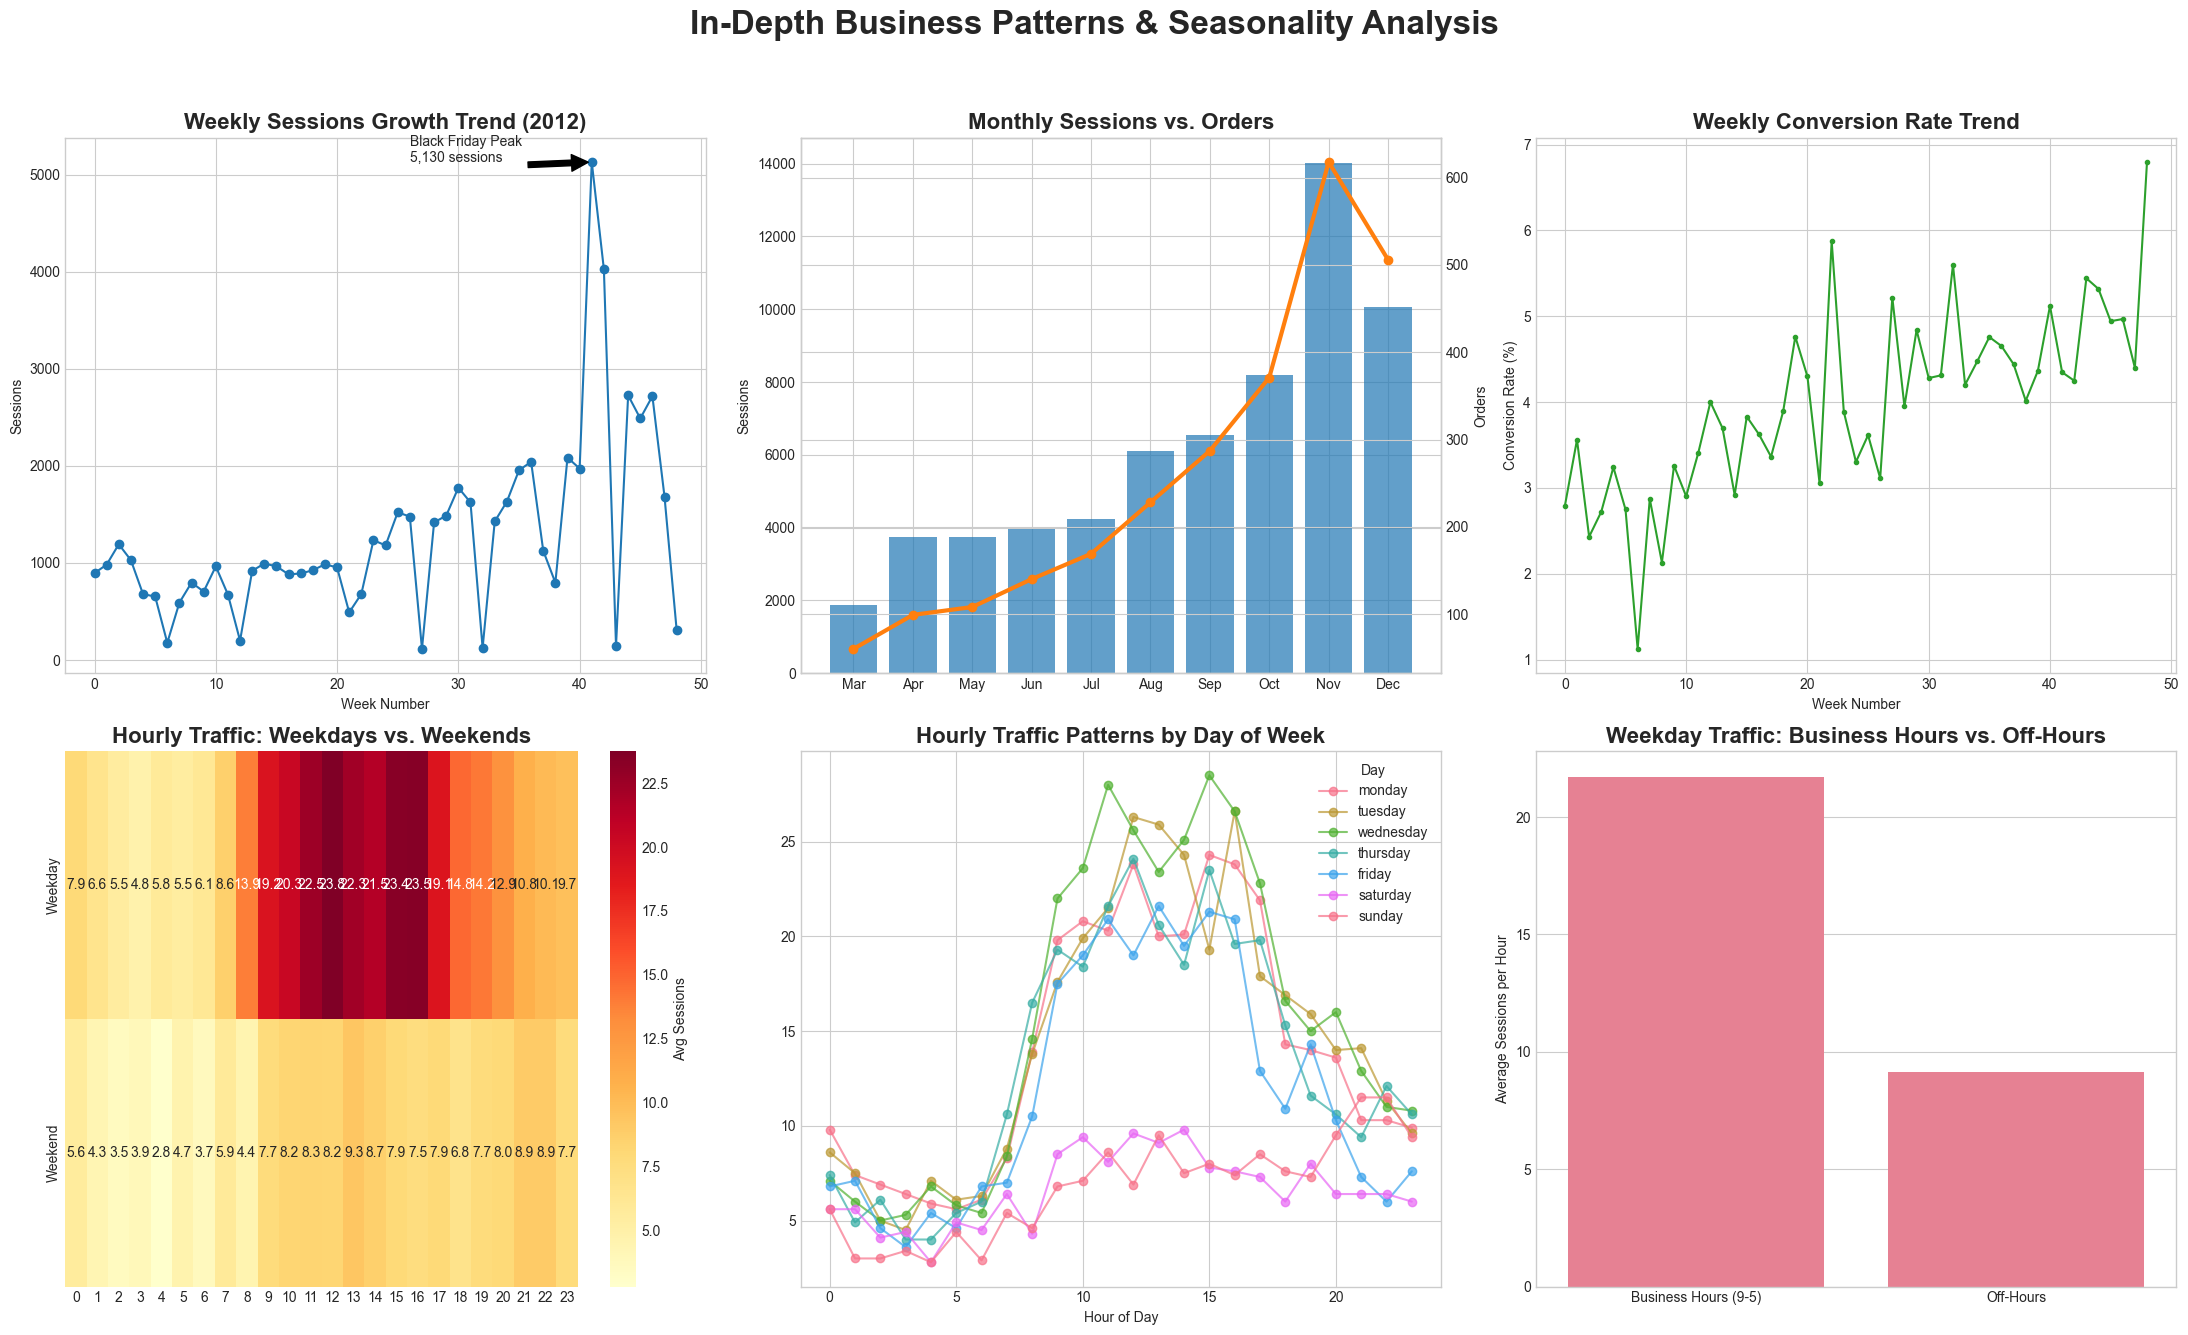

In [5]:
# --- Read Queries for Deeper Seasonality Analysis ---
with open('01_traffic_and_channel_analysis/analysing-business-patterns-and-seasonality.sql', 'r') as file:
    sql_queries = file.read().split(';')
sql_queries = [q.strip() for q in sql_queries if q.strip()]

# Query 1: Weekly sessions and orders
df_weekly = pd.read_sql(sql_queries[0], engine)

# Query 2: Hourly patterns by day of the week (CORRECTED to use the 4th query, index 3)
df_hourly_raw = pd.read_sql(sql_queries[3], engine)

# --- Data Processing & Column Renaming ---
# Rename columns to match the original visualization script's expectations
df_hourly = df_hourly_raw.rename(columns={
    'hr': 'hour', 'mon_avg': 'monday', 'tue_avg': 'tuesday', 'wed_avg': 'wednesday',
    'thu_avg': 'thursday', 'fri_avg': 'friday', 'sat_avg': 'saturday', 'sun_avg': 'sunday'
})

df_weekly['conversion_rate'] = (df_weekly['orders'] / df_weekly['sessions']) * 100
monthly_agg = df_weekly.groupby('mo').agg({'sessions': 'sum', 'orders': 'sum'}).reset_index()
monthly_agg['month_name'] = monthly_agg['mo'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))


# --- Comprehensive Visualization (recreating your script's dashboard) ---
#fig, axes = plt.subplots(3, 2, figsize=(20, 24))
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('In-Depth Business Patterns & Seasonality Analysis', fontsize=24, fontweight='bold')

# 1. Weekly Sessions Growth Trend
axes[0, 0].plot(df_weekly.index, df_weekly['sessions'], marker='o', color='#1f77b4')
axes[0, 0].set_title('Weekly Sessions Growth Trend (2012)', fontweight='bold', fontsize=16)
axes[0, 0].set_xlabel('Week Number')
axes[0, 0].set_ylabel('Sessions')
max_idx = df_weekly['sessions'].idxmax()
axes[0, 0].annotate(f"Black Friday Peak\n{df_weekly.loc[max_idx, 'sessions']:,} sessions",
                   xy=(max_idx, df_weekly.loc[max_idx, 'sessions']),
                   xytext=(max_idx - 15, df_weekly.loc[max_idx, 'sessions']),
                   arrowprops=dict(facecolor='black', shrink=0.05))

# 2. Monthly Sessions & Orders
ax2_twin = axes[0, 1].twinx()
axes[0, 1].bar(monthly_agg['month_name'], monthly_agg['sessions'], color='#1f77b4', alpha=0.7, label='Sessions')
ax2_twin.plot(monthly_agg['month_name'], monthly_agg['orders'], color='#ff7f0e', marker='o', lw=3, label='Orders')
axes[0, 1].set_title('Monthly Sessions vs. Orders', fontweight='bold', fontsize=16)
axes[0, 1].set_ylabel('Sessions')
ax2_twin.set_ylabel('Orders')

# 3. Weekly Conversion Rate Trend
axes[0, 2].plot(df_weekly.index, df_weekly['conversion_rate'], marker='.', color='#2ca02c')
axes[0, 2].set_title('Weekly Conversion Rate Trend', fontweight='bold', fontsize=16)
axes[0, 2].set_ylabel('Conversion Rate (%)')
axes[0, 2].set_xlabel('Week Number')

# 4. Hourly Heatmap (Weekdays vs Weekends)
weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
weekends = ['saturday', 'sunday']
heatmap_data = pd.DataFrame({
    'Weekday': df_hourly[weekdays].mean(axis=1),
    'Weekend': df_hourly[weekends].mean(axis=1)
})
sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Avg Sessions'})
axes[1, 0].set_title('Hourly Traffic: Weekdays vs. Weekends', fontweight='bold', fontsize=16)

# 5. Daily Pattern Comparison
df_hourly.plot(x='hour', y=weekdays + weekends, ax=axes[1, 1], marker='o', alpha=0.7)
axes[1, 1].set_title('Hourly Traffic Patterns by Day of Week', fontweight='bold', fontsize=16)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].legend(title='Day')

# 6. Business Hours Analysis
business_hours = list(range(9, 18))
business_avg = df_hourly.loc[df_hourly['hour'].isin(business_hours), weekdays].mean().mean()
off_hours_avg = df_hourly.loc[~df_hourly['hour'].isin(business_hours), weekdays].mean().mean()
sns.barplot(x=['Business Hours (9-5)', 'Off-Hours'], y=[business_avg, off_hours_avg], ax=axes[1, 2])
axes[1, 2].set_title('Weekday Traffic: Business Hours vs. Off-Hours', fontweight='bold', fontsize=16)
axes[1, 2].set_ylabel('Average Sessions per Hour')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

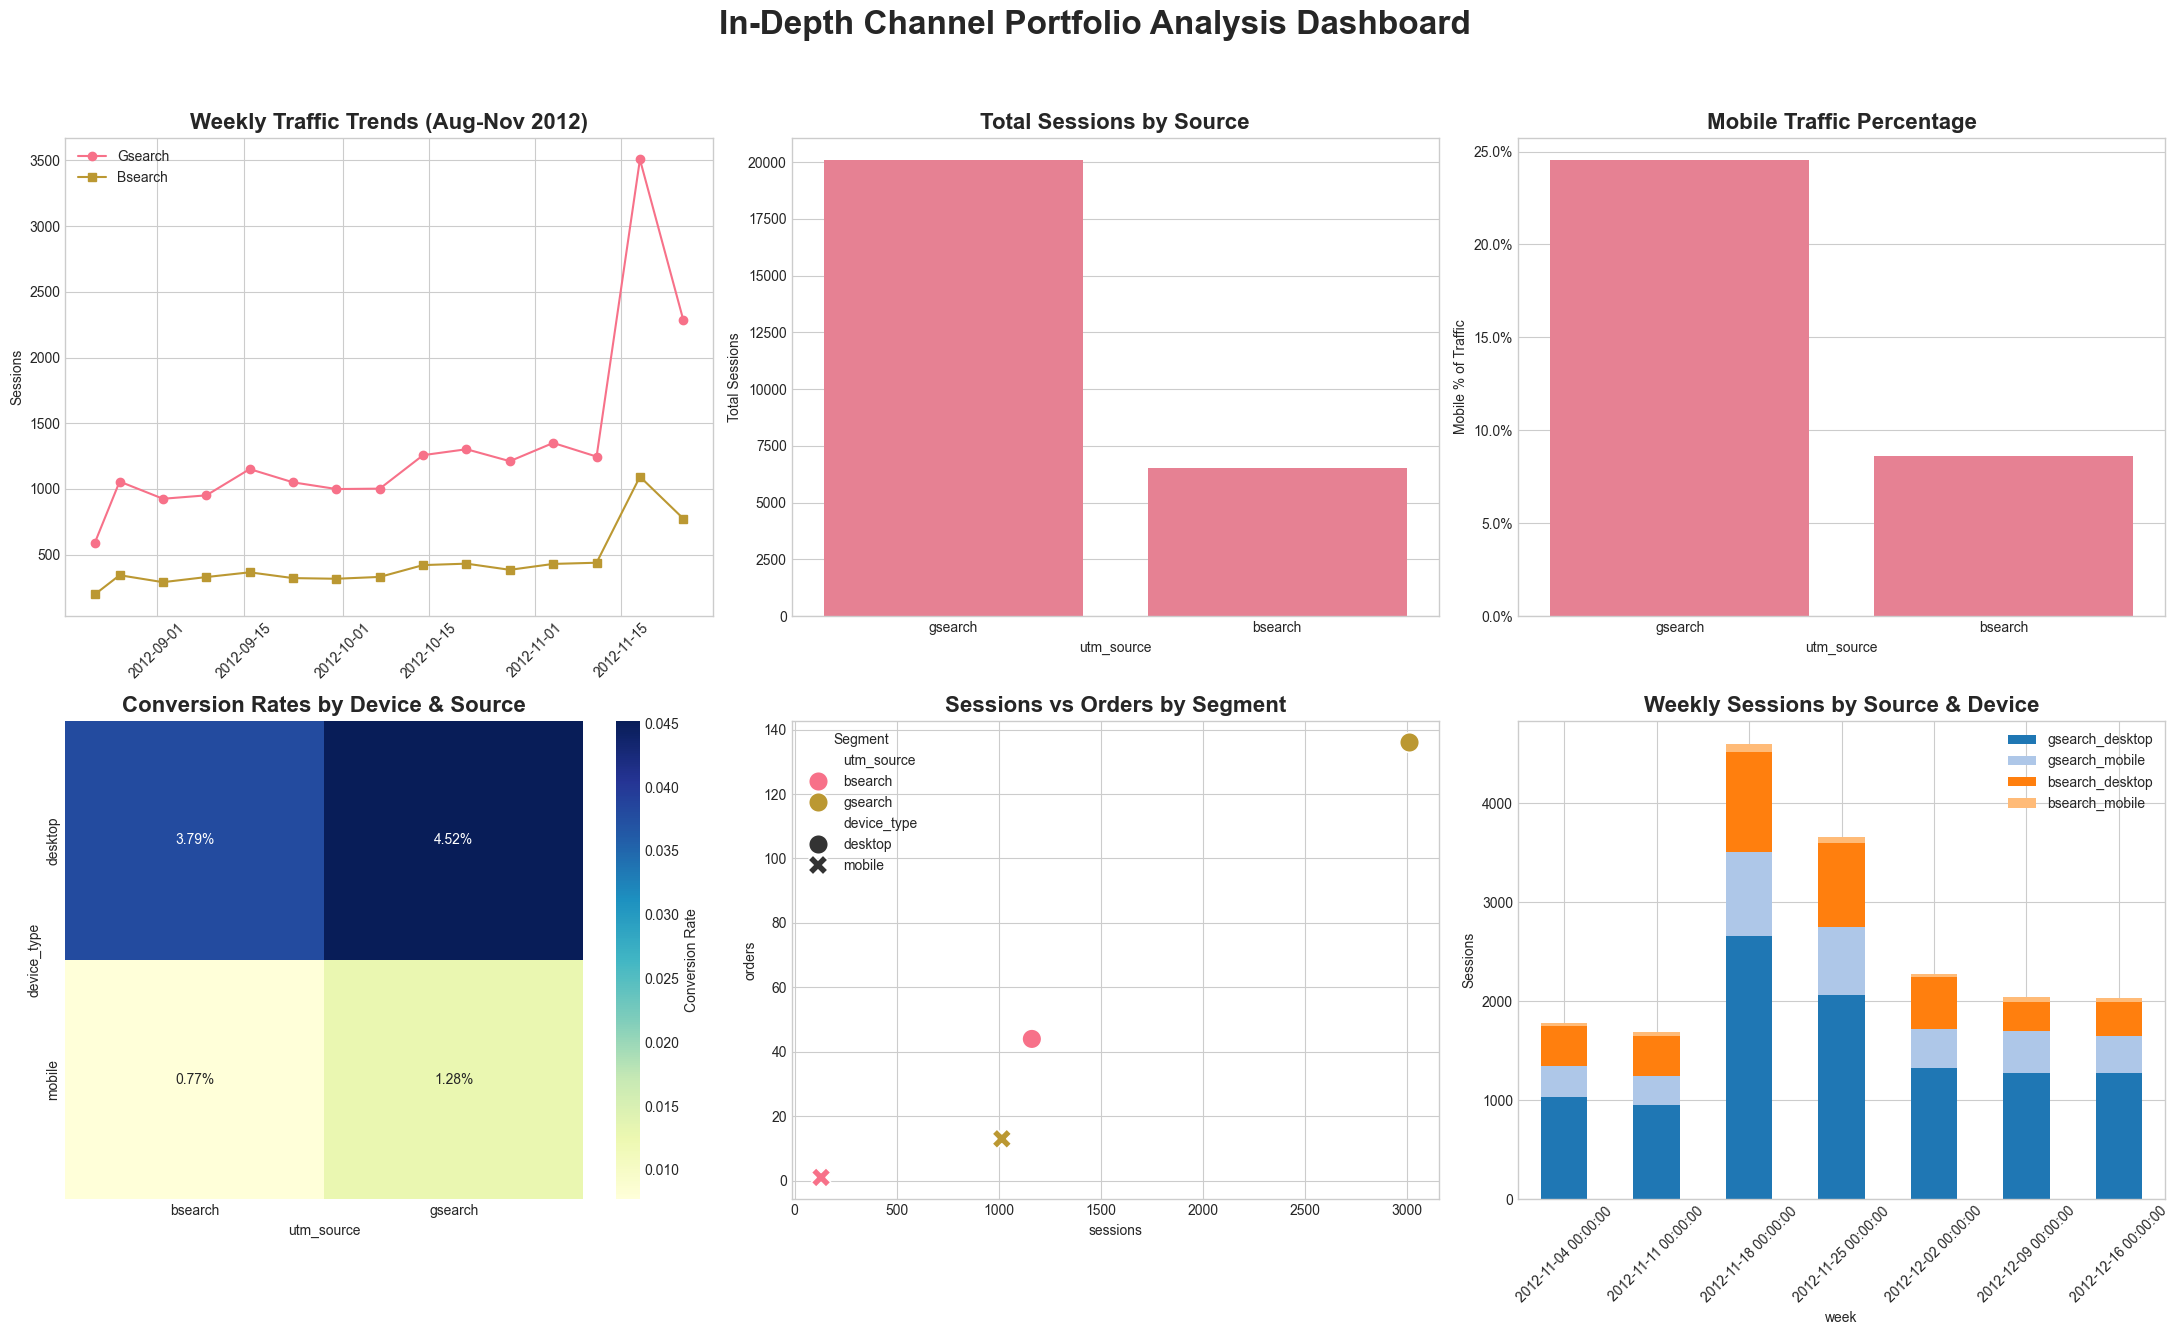

In [6]:
# --- Read Queries for Deeper Channel Portfolio Analysis ---
with open('01_traffic_and_channel_analysis/channel-portfolio-analysis.sql', 'r') as file:
    sql_queries = file.read().split(';')
sql_queries = [q.strip() for q in sql_queries if q.strip()]

# --- Execute All 4 Queries ---
df_weekly = pd.read_sql(sql_queries[0], engine)
df_mobile = pd.read_sql(sql_queries[1], engine)
df_conversion = pd.read_sql(sql_queries[2], engine)
df_detailed_raw = pd.read_sql(sql_queries[3], engine)

# --- Data Processing & Column Renaming (THE FIX) ---
df_weekly['week_start'] = pd.to_datetime(df_weekly['min(date(created_at))'])

# Rename columns to match the original visualization script's expectations
df_detailed = df_detailed_raw.rename(columns={
    'wk': 'week',
    'gsearch_desk_session': 'gsearch_desktop',
    'gsearch_mob_session': 'gsearch_mobile',
    'bsearch_desk_session': 'bsearch_desktop',
    'bsearch_mob_session': 'bsearch_mobile'
})
df_detailed['week'] = pd.to_datetime(df_detailed['week'])


# --- Comprehensive Visualization (recreating your script's dashboard) ---
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('In-Depth Channel Portfolio Analysis Dashboard', fontsize=24, fontweight='bold')

# 1. Weekly Traffic Trends
ax1 = axes[0, 0]
ax1.plot(df_weekly['week_start'], df_weekly['gsearch_sessions'], marker='o', label='Gsearch')
ax1.plot(df_weekly['week_start'], df_weekly['bsearch_sessions'], marker='s', label='Bsearch')
ax1.set_title('Weekly Traffic Trends (Aug-Nov 2012)', fontweight='bold', fontsize=16)
ax1.set_ylabel('Sessions')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# 2. Traffic Volume Comparison
ax2 = axes[0, 1]
sns.barplot(x='utm_source', y='sessions', data=df_mobile, ax=ax2)
ax2.set_title('Total Sessions by Source', fontweight='bold', fontsize=16)
ax2.set_ylabel('Total Sessions')

# 3. Mobile vs Desktop Split
ax3 = axes[0, 2]
df_mobile['pct_mobile_fmt'] = df_mobile['pct_mobile'] * 100
sns.barplot(x='utm_source', y='pct_mobile_fmt', data=df_mobile, ax=ax3)
ax3.set_title('Mobile Traffic Percentage', fontweight='bold', fontsize=16)
ax3.set_ylabel('Mobile % of Traffic')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

# 4. Conversion Rate Heatmap
ax4 = axes[1, 0]
conv_pivot = df_conversion.pivot(index='device_type', columns='utm_source', values='conv_rate')
sns.heatmap(conv_pivot, annot=True, fmt='.2%', cmap='YlGnBu', ax=ax4, cbar_kws={'label': 'Conversion Rate'})
ax4.set_title('Conversion Rates by Device & Source', fontweight='bold', fontsize=16)

# 5. Sessions vs Orders Scatter
ax5 = axes[1, 1]
sns.scatterplot(data=df_conversion, x='sessions', y='orders', hue='utm_source', style='device_type', s=200, ax=ax5)
ax5.set_title('Sessions vs Orders by Segment', fontweight='bold', fontsize=16)
ax5.legend(title='Segment')

# 6. Detailed Weekly Breakdown (Stacked Bar)
ax6 = axes[1, 2]
df_detailed.plot(x='week', y=['gsearch_desktop', 'gsearch_mobile', 'bsearch_desktop', 'bsearch_mobile'],
                 kind='bar', stacked=True, ax=ax6,
                 color=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78'])
ax6.set_title('Weekly Sessions by Source & Device', fontweight='bold', fontsize=16)
ax6.set_ylabel('Sessions')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\Nitro\AppData\Local\Temp\ipykernel_49512\276063974.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sessions', y='step_name', data=df_funnel, ax=ax1, palette='summer')
C:\Users\Nitro\AppData\Local\Temp\ipykernel_49512\276063974.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sessions_lost', y='step_name', data=df_funnel[df_funnel.index > 0], ax=ax2, palette='autumn')


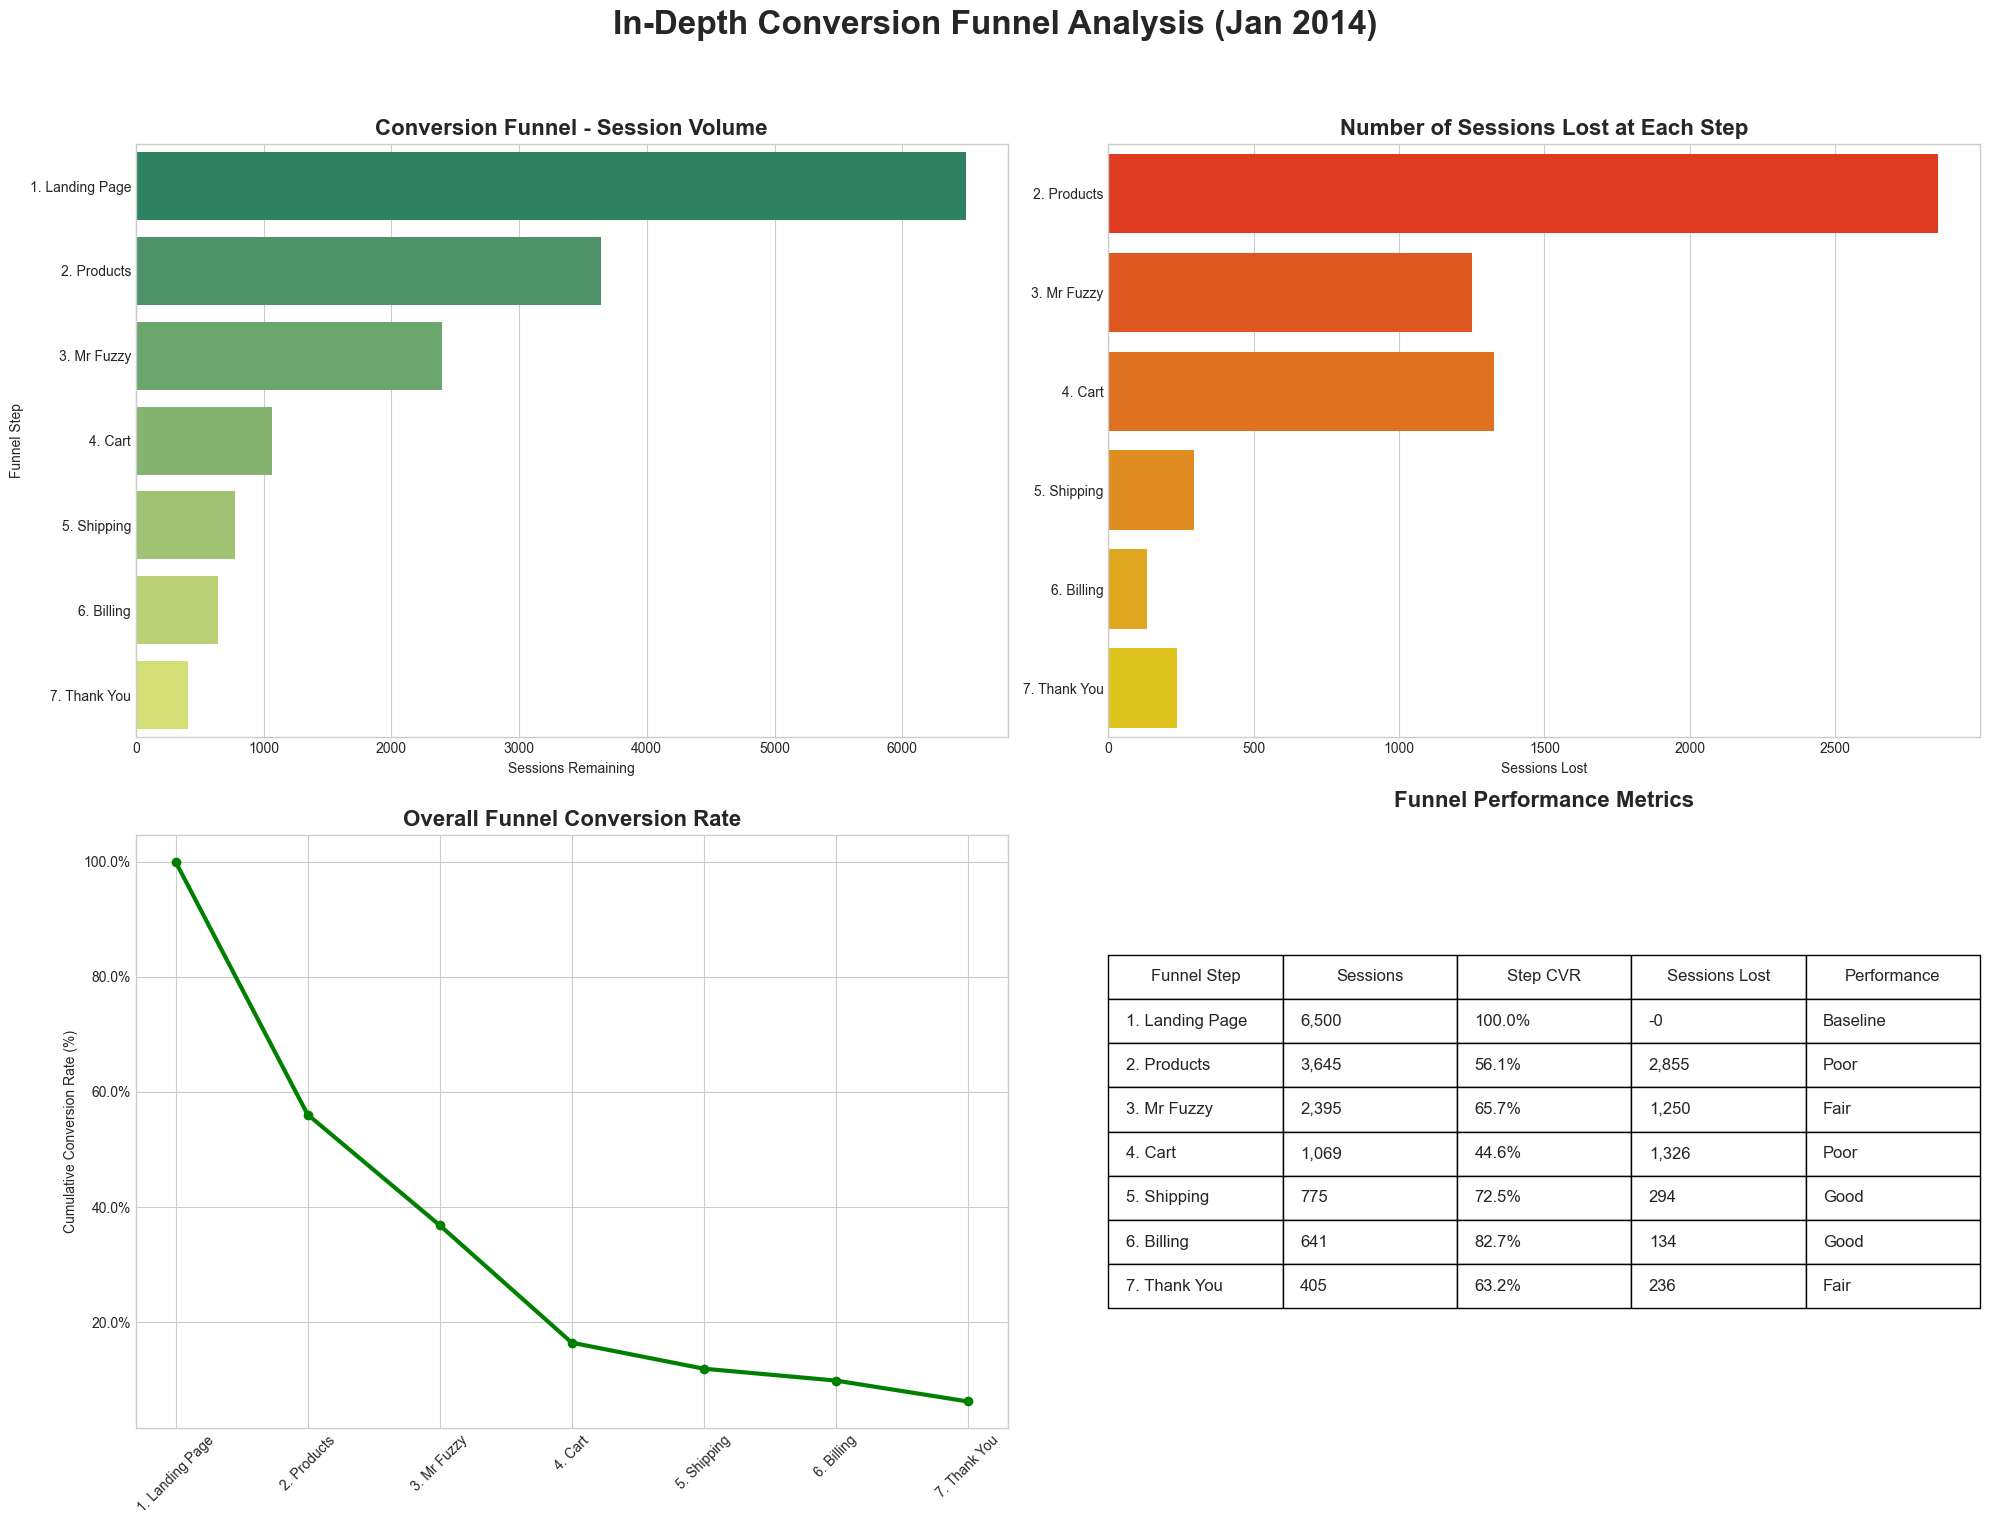

In [7]:
# --- Read and Construct the Corrected Sequential Funnel Query ---
# This query now correctly builds a sequential funnel, ensuring session counts only decrease.
sequential_funnel_query = """
WITH session_flags AS (
    SELECT
        ws.website_session_id,
        MAX(CASE WHEN pageview_url = '/lander-2' THEN 1 ELSE 0 END) AS to_lander,
        MAX(CASE WHEN pageview_url = '/products' THEN 1 ELSE 0 END) AS to_products,
        MAX(CASE WHEN pageview_url = '/the-original-mr-fuzzy' THEN 1 ELSE 0 END) AS to_mrfuzzy,
        MAX(CASE WHEN pageview_url = '/cart' THEN 1 ELSE 0 END) AS to_cart,
        MAX(CASE WHEN pageview_url = '/shipping' THEN 1 ELSE 0 END) AS to_shipping,
        MAX(CASE WHEN pageview_url = '/billing-2' THEN 1 ELSE 0 END) AS to_billing,
        MAX(CASE WHEN pageview_url = '/thank-you-for-your-order' THEN 1 ELSE 0 END) AS to_thankyou
    FROM website_sessions ws
    LEFT JOIN website_pageviews wp ON ws.website_session_id = wp.website_session_id
    WHERE ws.created_at BETWEEN '2014-01-01' AND '2014-02-01'
    GROUP BY ws.website_session_id
)
SELECT '1. Landing Page' AS step_name, COUNT(website_session_id) AS sessions FROM session_flags WHERE to_lander = 1
UNION
SELECT '2. Products', COUNT(website_session_id) FROM session_flags WHERE to_lander = 1 AND to_products = 1
UNION
SELECT '3. Mr Fuzzy', COUNT(website_session_id) FROM session_flags WHERE to_lander = 1 AND to_products = 1 AND to_mrfuzzy = 1
UNION
SELECT '4. Cart', COUNT(website_session_id) FROM session_flags WHERE to_lander = 1 AND to_products = 1 AND to_mrfuzzy = 1 AND to_cart = 1
UNION
SELECT '5. Shipping', COUNT(website_session_id) FROM session_flags WHERE to_lander = 1 AND to_products = 1 AND to_mrfuzzy = 1 AND to_cart = 1 AND to_shipping = 1
UNION
SELECT '6. Billing', COUNT(website_session_id) FROM session_flags WHERE to_lander = 1 AND to_products = 1 AND to_mrfuzzy = 1 AND to_cart = 1 AND to_shipping = 1 AND to_billing = 1
UNION
SELECT '7. Thank You', COUNT(website_session_id) FROM session_flags WHERE to_lander = 1 AND to_products = 1 AND to_mrfuzzy = 1 AND to_cart = 1 AND to_shipping = 1 AND to_billing = 1 AND to_thankyou = 1;
"""
df_funnel = pd.read_sql(sequential_funnel_query, engine)

# --- Data Processing for Visualization ---
df_funnel['sessions_lost'] = -df_funnel['sessions'].diff().fillna(0)
df_funnel['cumulative_conversion'] = (df_funnel['sessions'] / df_funnel['sessions'].iloc[0]) * 100


# --- Simplified and Corrected Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('In-Depth Conversion Funnel Analysis (Jan 2014)', fontsize=24, fontweight='bold')

# 1. Classic Funnel Visualization
ax1 = axes[0, 0]
sns.barplot(x='sessions', y='step_name', data=df_funnel, ax=ax1, palette='summer')
ax1.set_title('Conversion Funnel - Session Volume', fontweight='bold', fontsize=16)
ax1.set_xlabel('Sessions Remaining')
ax1.set_ylabel('Funnel Step')

# 2. Where Are We Losing Users? (Session Dropoff)
ax2 = axes[0, 1]
sns.barplot(x='sessions_lost', y='step_name', data=df_funnel[df_funnel.index > 0], ax=ax2, palette='autumn')
ax2.set_title('Number of Sessions Lost at Each Step', fontweight='bold', fontsize=16)
ax2.set_xlabel('Sessions Lost')
ax2.set_ylabel('')

# 3. Overall Funnel Efficiency (Cumulative Conversion)
ax3 = axes[1, 0]
ax3.plot(df_funnel['step_name'], df_funnel['cumulative_conversion'], marker='o', lw=3, color='green')
ax3.set_title('Overall Funnel Conversion Rate', fontweight='bold', fontsize=16)
ax3.set_ylabel('Cumulative Conversion Rate (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

# 4. Funnel Performance Metrics Table
ax4 = axes[1, 1]
ax4.axis('off')
df_funnel['step_conversion'] = df_funnel['sessions'] / df_funnel['sessions'].shift(1)
metrics_data = []
for i, row in df_funnel.iterrows():
    performance = "Good" if row['step_conversion'] >= 0.7 else "Fair" if row['step_conversion'] >= 0.6 else "Poor"
    if i == 0: performance = "Baseline"
    metrics_data.append([
        row['step_name'], f"{row['sessions']:,}", f"{row['step_conversion']*100:.1f}%" if i > 0 else "100.0%",
        f"{row['sessions_lost']:,.0f}", performance
    ])
table = ax4.table(cellText=metrics_data,
                  colLabels=['Funnel Step', 'Sessions', 'Step CVR', 'Sessions Lost', 'Performance'],
                  loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2.5)
ax4.set_title('Funnel Performance Metrics', fontweight='bold', fontsize=16, pad=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

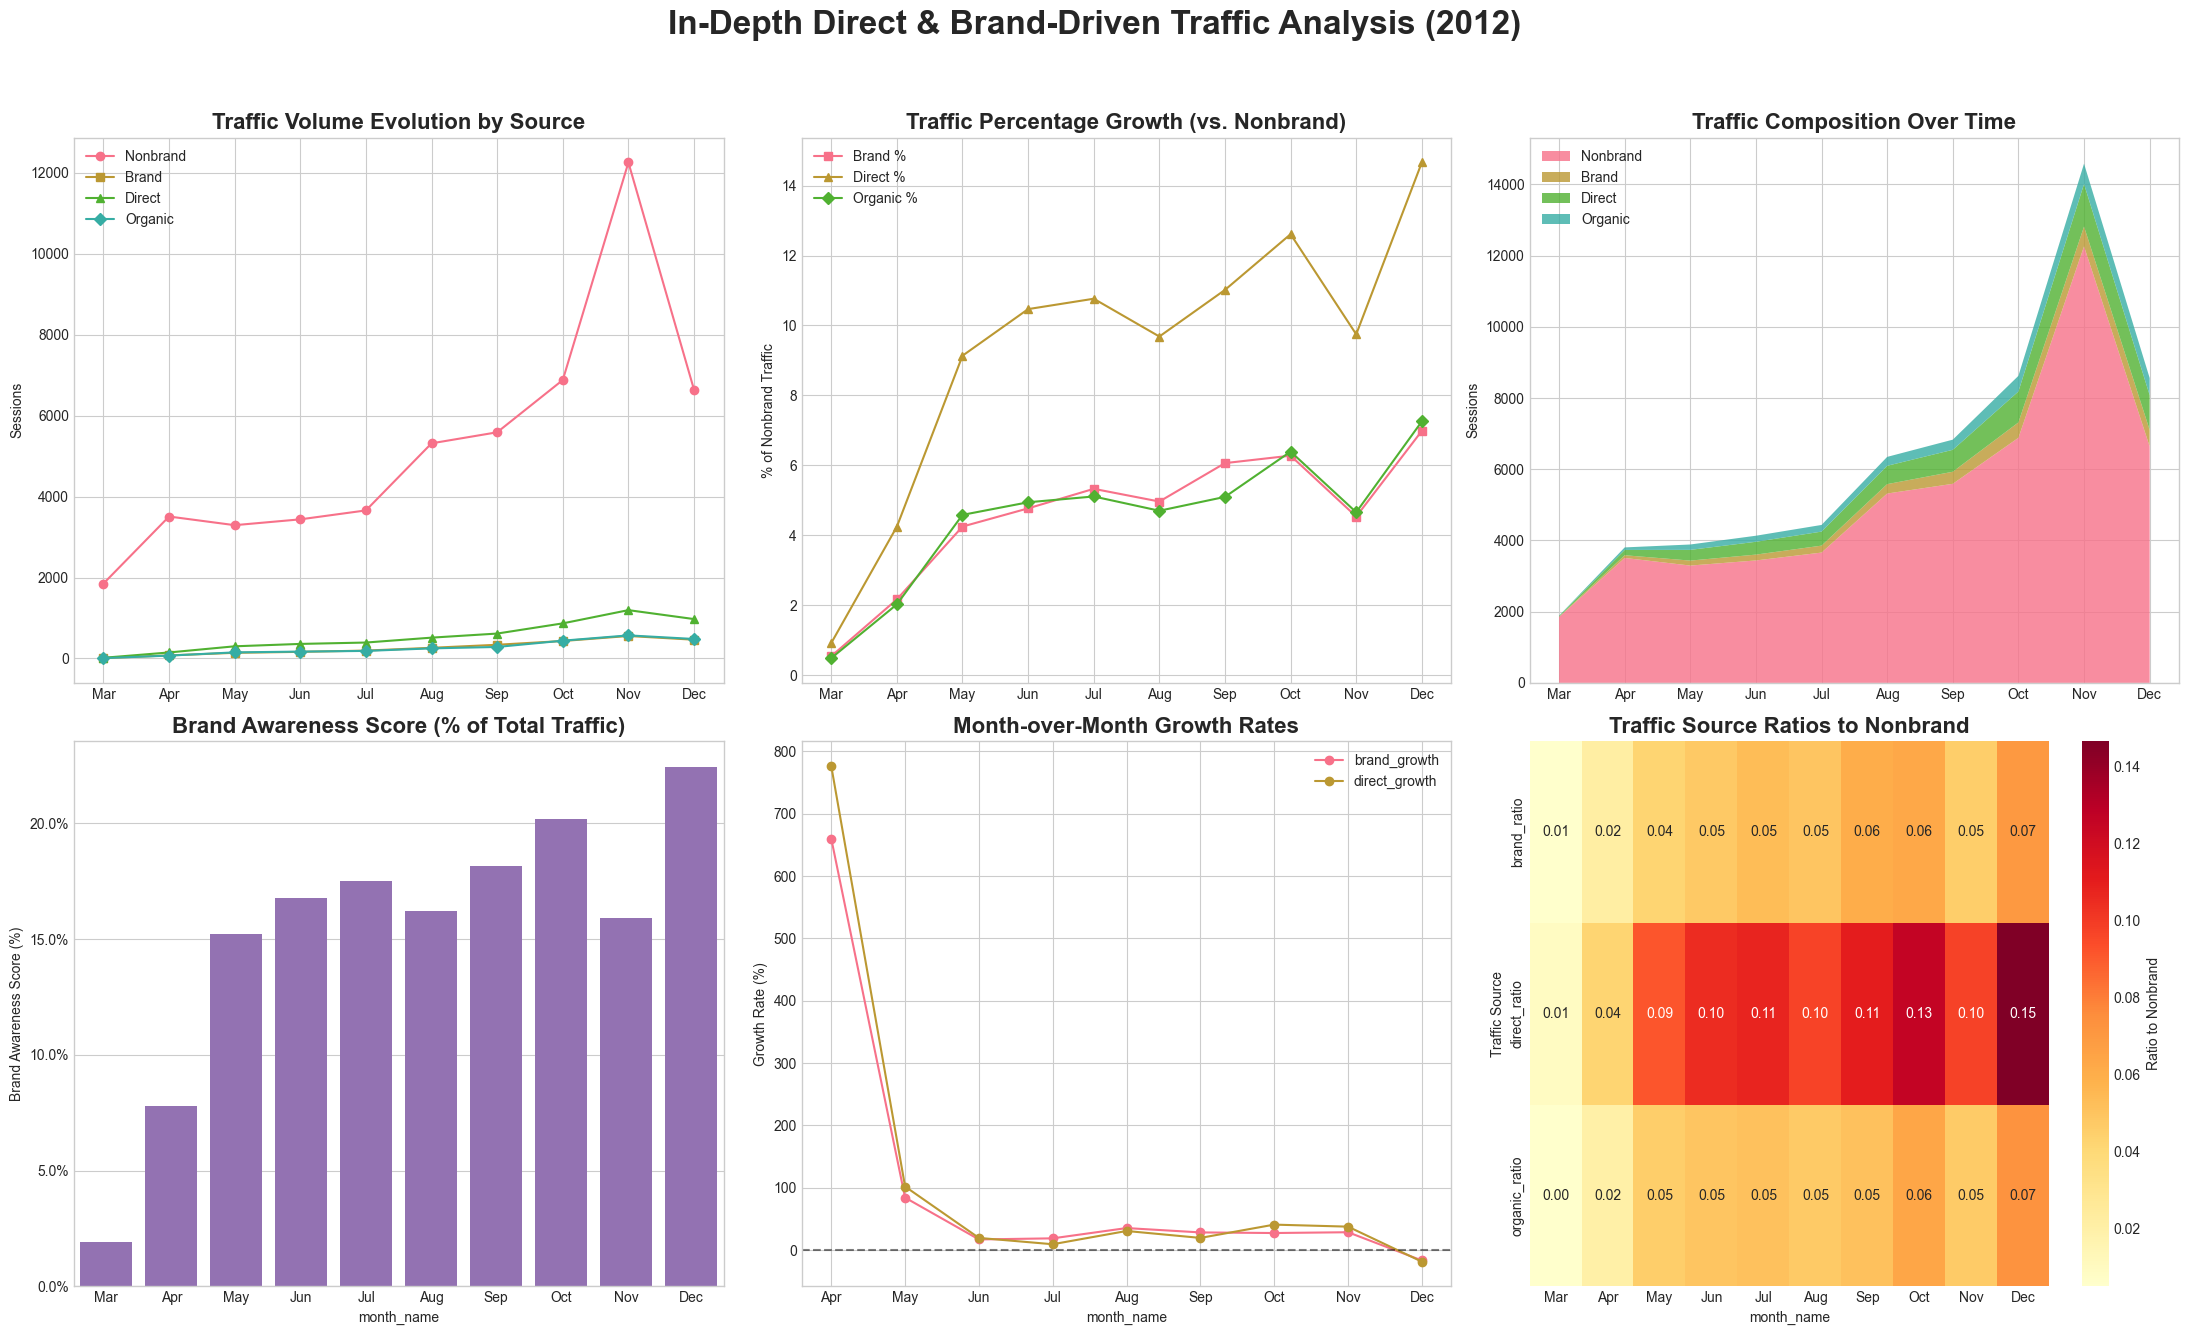

In [8]:
# --- Read Query for Direct & Brand Traffic Analysis ---
with open('01_traffic_and_channel_analysis/analysing-direct-brand-driven-traffic.sql', 'r') as file:
    query = file.read()
df_brand_traffic_raw = pd.read_sql(query, engine)

# --- Data Processing & Column Renaming (THE FIX) ---
# Rename the columns from the SQL query to match what the plotting code expects
df_brand_traffic = df_brand_traffic_raw.rename(columns={
    'p1': 'brand_pct',
    'p2': 'direct_pct',
    'p3': 'organic_pct'
})

df_brand_traffic['month_name'] = df_brand_traffic['mo'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))
df_brand_traffic['total_traffic'] = df_brand_traffic['nonbrand'] + df_brand_traffic['brand'] + df_brand_traffic['direct'] + df_brand_traffic['organic']
df_brand_traffic['brand_awareness_score'] = (df_brand_traffic['brand'] + df_brand_traffic['direct'] + df_brand_traffic['organic']) / df_brand_traffic['total_traffic'] * 100


# --- Comprehensive Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('In-Depth Direct & Brand-Driven Traffic Analysis (2012)', fontsize=24, fontweight='bold')

# 1. Traffic Volume Evolution
ax1 = axes[0, 0]
ax1.plot(df_brand_traffic['month_name'], df_brand_traffic['nonbrand'], marker='o', label='Nonbrand')
ax1.plot(df_brand_traffic['month_name'], df_brand_traffic['brand'], marker='s', label='Brand')
ax1.plot(df_brand_traffic['month_name'], df_brand_traffic['direct'], marker='^', label='Direct')
ax1.plot(df_brand_traffic['month_name'], df_brand_traffic['organic'], marker='D', label='Organic')
ax1.set_title('Traffic Volume Evolution by Source', fontweight='bold', fontsize=16)
ax1.set_ylabel('Sessions')
ax1.legend()

# 2. Percentage Growth Trends (vs. Nonbrand)
ax2 = axes[0, 1]
ax2.plot(df_brand_traffic['month_name'], df_brand_traffic['brand_pct'], marker='s', label='Brand %')
ax2.plot(df_brand_traffic['month_name'], df_brand_traffic['direct_pct'], marker='^', label='Direct %')
ax2.plot(df_brand_traffic['month_name'], df_brand_traffic['organic_pct'], marker='D', label='Organic %')
ax2.set_title('Traffic Percentage Growth (vs. Nonbrand)', fontweight='bold', fontsize=16)
ax2.set_ylabel('% of Nonbrand Traffic')
ax2.legend()

# 3. Stacked Area Chart - Traffic Composition
ax3 = axes[0, 2]
ax3.stackplot(df_brand_traffic['month_name'], df_brand_traffic['nonbrand'], df_brand_traffic['brand'], df_brand_traffic['direct'], df_brand_traffic['organic'],
              labels=['Nonbrand', 'Brand', 'Direct', 'Organic'], alpha=0.8)
ax3.set_title('Traffic Composition Over Time', fontweight='bold', fontsize=16)
ax3.set_ylabel('Sessions')
ax3.legend(loc='upper left')

# 4. Brand Awareness Score
ax4 = axes[1, 0]
sns.barplot(x='month_name', y='brand_awareness_score', data=df_brand_traffic, ax=ax4, color='#9467bd')
ax4.set_title('Brand Awareness Score (% of Total Traffic)', fontweight='bold', fontsize=16)
ax4.set_ylabel('Brand Awareness Score (%)')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

# 5. Month-over-Month Growth Rates
ax5 = axes[1, 1]
df_brand_traffic['brand_growth'] = df_brand_traffic['brand'].pct_change() * 100
df_brand_traffic['direct_growth'] = df_brand_traffic['direct'].pct_change() * 100
df_brand_traffic.plot(x='month_name', y=['brand_growth', 'direct_growth'], ax=ax5, marker='o')
ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax5.set_title('Month-over-Month Growth Rates', fontweight='bold', fontsize=16)
ax5.set_ylabel('Growth Rate (%)')
ax5.legend()

# 6. Traffic Source Ratios Heatmap
ax6 = axes[1, 2]
df_brand_traffic['brand_ratio'] = df_brand_traffic['brand'] / df_brand_traffic['nonbrand']
df_brand_traffic['direct_ratio'] = df_brand_traffic['direct'] / df_brand_traffic['nonbrand']
df_brand_traffic['organic_ratio'] = df_brand_traffic['organic'] / df_brand_traffic['nonbrand']
ratio_data = df_brand_traffic.set_index('month_name')[['brand_ratio', 'direct_ratio', 'organic_ratio']].T
sns.heatmap(ratio_data, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'Ratio to Nonbrand'})
ax6.set_title('Traffic Source Ratios to Nonbrand', fontweight='bold', fontsize=16)
ax6.set_ylabel('Traffic Source')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

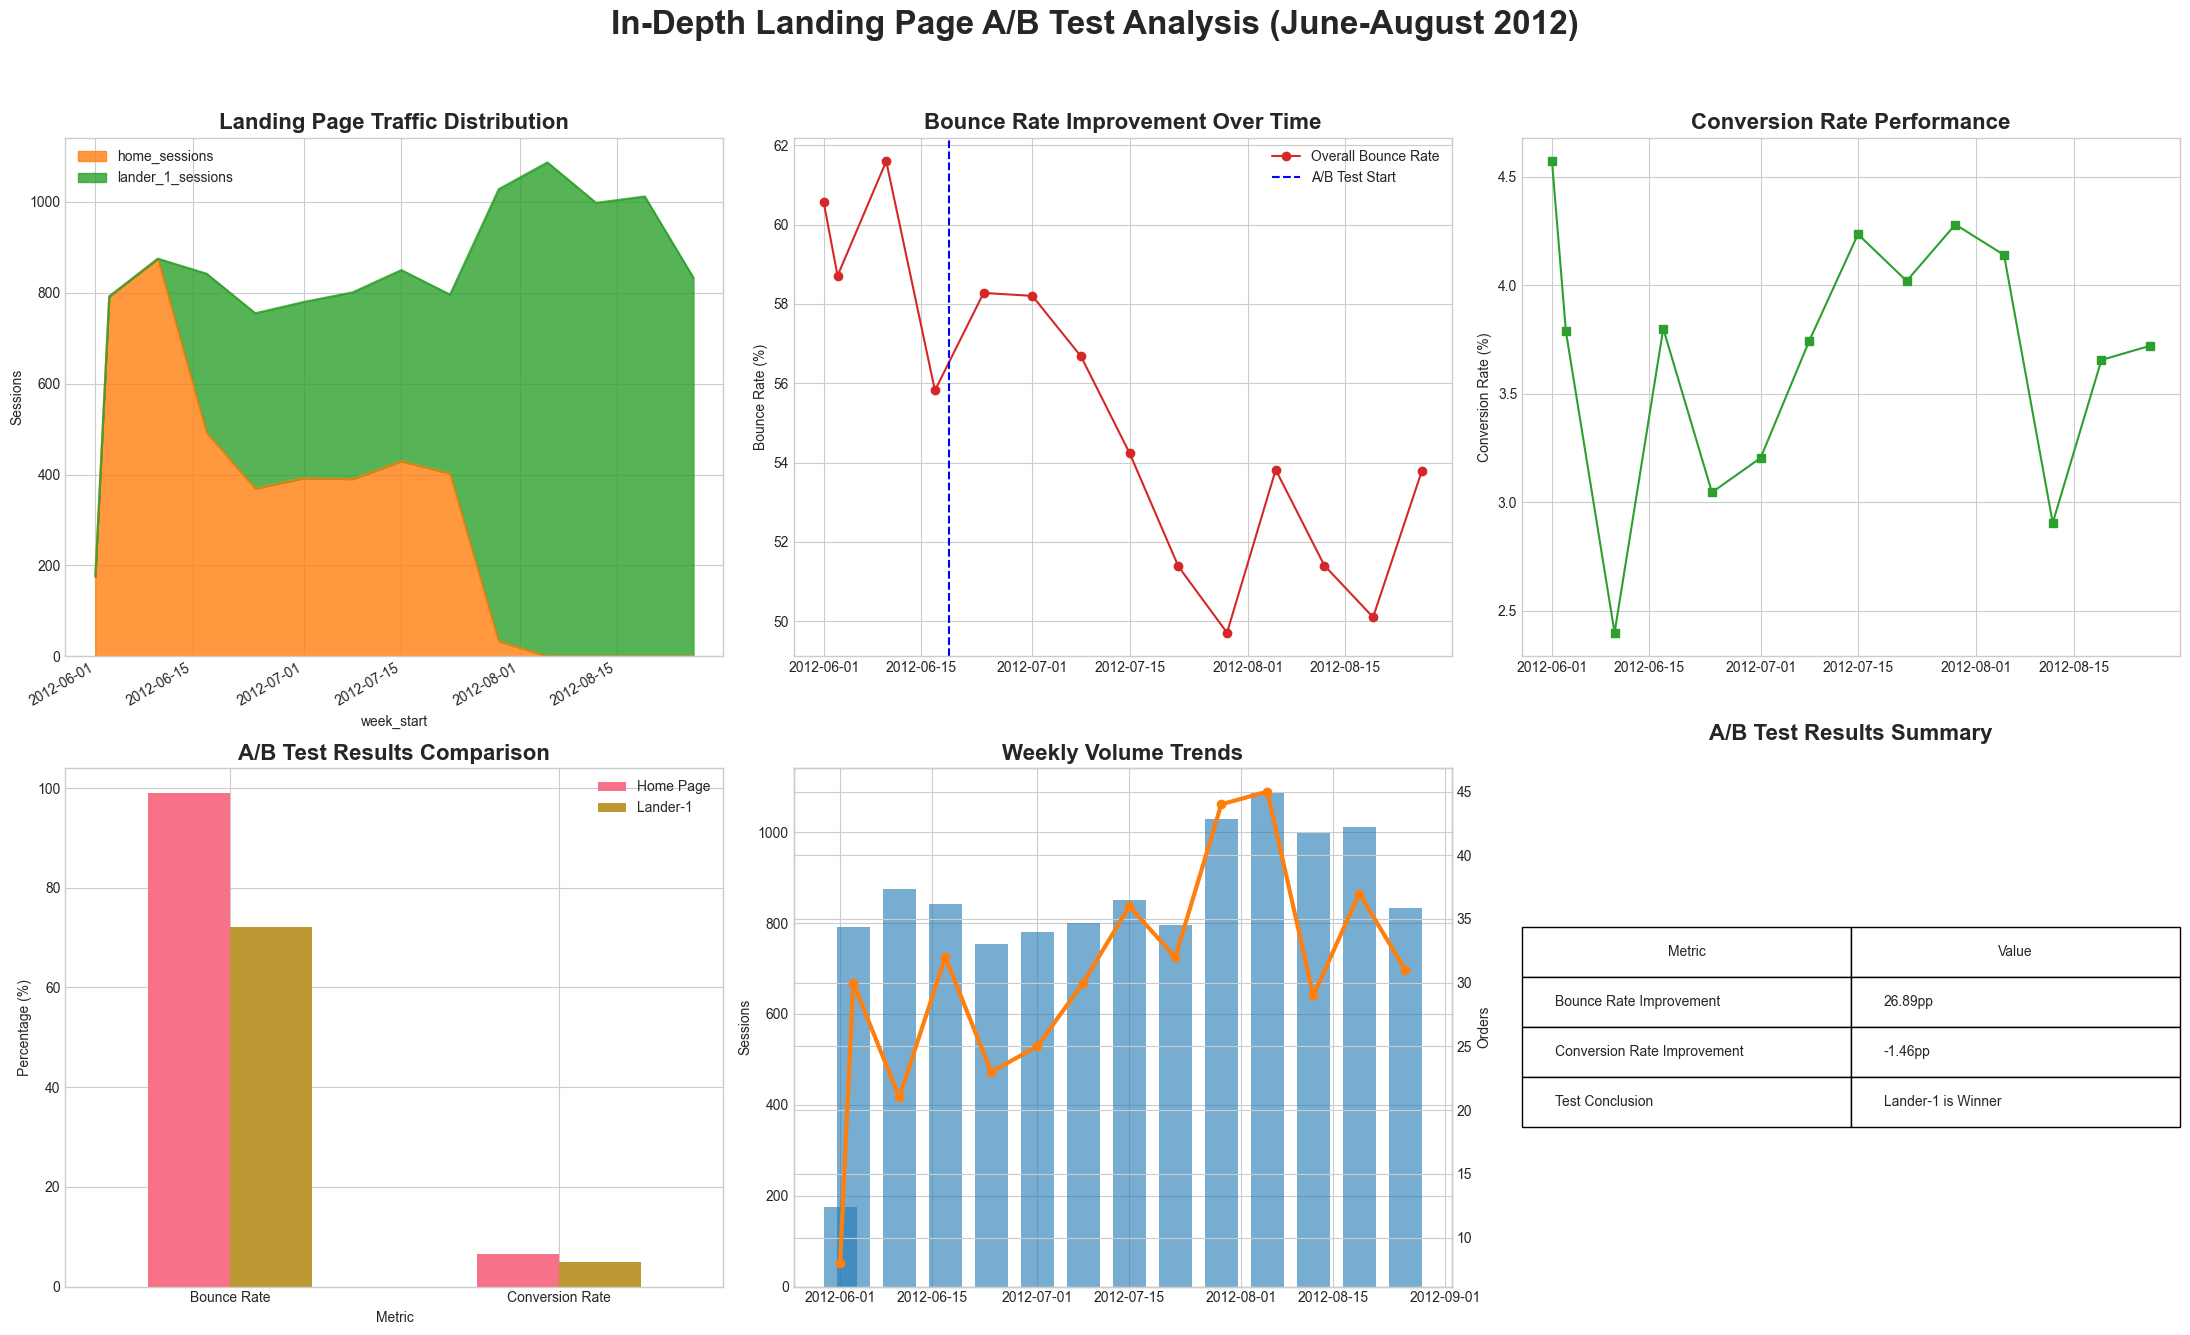

In [9]:
# --- Read and Construct Query for Landing Page A/B Test Analysis ---
# This query gathers weekly data on sessions, bounces, orders, and traffic split for the test period.
landing_page_query = """
WITH session_details AS (
    SELECT
        ws.website_session_id,
        ws.created_at,
        MIN(wp.website_pageview_id) AS first_pageview_id,
        COUNT(wp.website_pageview_id) AS pageview_count,
        MAX(CASE WHEN o.order_id IS NOT NULL THEN 1 ELSE 0 END) AS has_order
    FROM website_sessions ws
    LEFT JOIN website_pageviews wp ON ws.website_session_id = wp.website_session_id
    LEFT JOIN orders o ON ws.website_session_id = o.website_session_id
    WHERE ws.created_at BETWEEN '2012-06-01' AND '2012-08-31'
      AND ws.utm_source = 'gsearch' AND ws.utm_campaign = 'nonbrand'
    GROUP BY ws.website_session_id
),
sessions_with_landing_page AS (
    SELECT
        sd.website_session_id,
        sd.created_at,
        sd.pageview_count,
        sd.has_order,
        wp.pageview_url AS landing_page
    FROM session_details sd
    LEFT JOIN website_pageviews wp ON sd.first_pageview_id = wp.website_pageview_id
)
SELECT
    MIN(DATE(created_at)) AS week_start,
    COUNT(website_session_id) AS total_sessions,
    COUNT(CASE WHEN pageview_count = 1 THEN website_session_id ELSE NULL END) AS bounced_sessions,
    COUNT(CASE WHEN landing_page = '/home' THEN website_session_id ELSE NULL END) AS home_sessions,
    COUNT(CASE WHEN landing_page = '/lander-1' THEN website_session_id ELSE NULL END) AS lander_1_sessions,
    SUM(has_order) AS orders
FROM sessions_with_landing_page
GROUP BY YEARWEEK(created_at)
ORDER BY week_start;
"""
df = pd.read_sql(landing_page_query, engine)

# --- Data Processing for Visualization ---
df['week_start'] = pd.to_datetime(df['week_start'])
df['bounce_rate'] = (df['bounced_sessions'] / df['total_sessions']) * 100
df['conversion_rate'] = (df['orders'] / df['total_sessions']) * 100

# --- Comprehensive Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('In-Depth Landing Page A/B Test Analysis (June-August 2012)', fontsize=24, fontweight='bold')

# 1. Landing Page Traffic Distribution
ax1 = axes[0, 0]
df.plot(x='week_start', y=['home_sessions', 'lander_1_sessions'], kind='area', stacked=True, ax=ax1,
        color=['#ff7f0e', '#2ca02c'], alpha=0.8)
ax1.set_title('Landing Page Traffic Distribution', fontweight='bold', fontsize=16)
ax1.set_ylabel('Sessions')

# 2. Bounce Rate Trend
ax2 = axes[0, 1]
ax2.plot(df['week_start'], df['bounce_rate'], marker='o', color='#d62728', label='Overall Bounce Rate')
ax2.set_title('Bounce Rate Improvement Over Time', fontweight='bold', fontsize=16)
ax2.set_ylabel('Bounce Rate (%)')
ax2.axvline(pd.to_datetime('2012-06-19'), color='blue', linestyle='--', label='A/B Test Start')
ax2.legend()

# 3. Conversion Rate Performance
ax3 = axes[0, 2]
ax3.plot(df['week_start'], df['conversion_rate'], marker='s', color='#2ca02c', label='Conversion Rate')
ax3.set_title('Conversion Rate Performance', fontweight='bold', fontsize=16)
ax3.set_ylabel('Conversion Rate (%)')

# 4. A/B Test Performance Comparison
ax4 = axes[1, 0]
home_total_sessions = df['home_sessions'].sum()
lander_total_sessions = df['lander_1_sessions'].sum()
home_bounced = df[df['home_sessions'] > 0]['bounced_sessions'].sum()
lander_bounced = df[df['lander_1_sessions'] > 0]['bounced_sessions'].sum()
home_orders = df[df['home_sessions'] > 0]['orders'].sum()
lander_orders = df[df['lander_1_sessions'] > 0]['orders'].sum()

home_bounce_rate = (home_bounced / home_total_sessions) * 100 if home_total_sessions else 0
lander_bounce_rate = (lander_bounced / lander_total_sessions) * 100 if lander_total_sessions else 0
home_conv_rate = (home_orders / home_total_sessions) * 100 if home_total_sessions else 0
lander_conv_rate = (lander_orders / lander_total_sessions) * 100 if lander_total_sessions else 0

comparison_data = pd.DataFrame({
    'Metric': ['Bounce Rate', 'Conversion Rate'],
    'Home Page': [home_bounce_rate, home_conv_rate],
    'Lander-1': [lander_bounce_rate, lander_conv_rate]
}).set_index('Metric')
comparison_data.plot(kind='bar', ax=ax4)
ax4.set_title('A/B Test Results Comparison', fontweight='bold', fontsize=16)
ax4.set_ylabel('Percentage (%)')
ax4.tick_params(axis='x', rotation=0)

# 5. Weekly Sessions and Orders Volume
ax5 = axes[1, 1]
ax5_twin = ax5.twinx()
ax5.bar(df['week_start'], df['total_sessions'], alpha=0.6, color='#1f77b4', label='Sessions', width=5)
ax5_twin.plot(df['week_start'], df['orders'], marker='o', lw=3, color='#ff7f0e', label='Orders')
ax5.set_title('Weekly Volume Trends', fontweight='bold', fontsize=16)
ax5.set_ylabel('Sessions')
ax5_twin.set_ylabel('Orders')

# 6. Test Results Summary Table
ax6 = axes[1, 2]
ax6.axis('off')
summary_data = [
    ['Bounce Rate Improvement', f"{home_bounce_rate - lander_bounce_rate:.2f}pp"],
    ['Conversion Rate Improvement', f"{lander_conv_rate - home_conv_rate:.2f}pp"],
    ['Test Conclusion', 'Lander-1 is Winner']
]
table = ax6.table(cellText=summary_data, colLabels=['Metric', 'Value'], loc='center', cellLoc='left')
table.scale(1, 2.5)
ax6.set_title('A/B Test Results Summary', fontweight='bold', fontsize=16, pad=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()